In [4]:
#1
# Import libraries and dependencies
import numpy as np
import pandas as pd
import os
import requests
from pathlib import Path
%matplotlib inline
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.metrics import r2_score
from datetime import date
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
warnings.filterwarnings("ignore")
from MCForecastTools import MCSimulation

In [5]:
#2
# Import API data
from dotenv import load_dotenv
import alpaca_trade_api as tradeapi

In [6]:
#3
# Load .env enviroment variables
load_dotenv("ProjectAPI.env")

True

In [7]:
#4
# Set the tickers
tickers = ["SPY", "IWM", "EZU", "EWU", "EWJ", "EWZ", "EWA", "EWC", "MCHI", "EWW"]

# Create the shares DataFrame
df_etf = pd.DataFrame(index=tickers)

In [8]:
#5
# Set Alpaca API key and secret
alpaca_api_key = os.getenv("Alpaca_API_Key")
alpaca_secret_key = os.getenv("Alpaca_Secret_Key")

# Verify that Alpaca key and secret were correctly loaded
print(f"Alpaca Key type: {type(alpaca_api_key)}")
print(f"Alpaca Secret Key type: {type(alpaca_secret_key)}")

Alpaca Key type: <class 'str'>
Alpaca Secret Key type: <class 'str'>


In [9]:
#6
# Create the Alpaca API object
alpaca = tradeapi.REST(
    alpaca_api_key,
    alpaca_secret_key,
    api_version="v2")

In [33]:
#6a
# Create current date variable
import datetime
today = datetime.date.today()
historical = first - datetime.timedelta(days=550)

In [17]:
#6b
# Format current date as ISO format
# Set start and end datetimes of 18 months
start_date = pd.Timestamp(historical, tz="America/New_York").isoformat()
end_date = pd.Timestamp(today, tz="America/New_York").isoformat()

In [18]:
#7
# Set timeframe to 18 months for the Alpaca API
timeframe = "1Day"

In [19]:
#8
# Get 18 months of pricing data for ETF portfolio
df_portfolio = alpaca.get_bars(tickers, timeframe, start=start_date, end=end_date).df

df_portfolio

,close,high,low,trade_count,open,volume,vwap,symbol
timestamp,,,,,,,,
2022-05-31 04:00:00+00:00,24.68,24.845,24.6150,8482,24.74,5155490,24.730909,EWA
2022-06-01 04:00:00+00:00,24.76,25.150,24.6250,8884,25.11,5565554,24.803130,EWA
2022-06-02 04:00:00+00:00,25.34,25.355,24.8700,16642,24.92,9199605,25.147539,EWA
2022-06-03 04:00:00+00:00,24.98,25.135,24.8900,8361,25.03,5086025,24.977771,EWA
2022-06-06 04:00:00+00:00,24.94,25.160,24.8700,5850,25.12,3599079,24.982696,EWA
...,...,...,...,...,...,...,...,...
2023-12-15 05:00:00+00:00,469.33,470.700,467.4263,667849,469.49,141529826,469.349350,SPY
2023-12-18 05:00:00+00:00,471.97,472.980,469.8929,459241,470.98,70375385,471.855993,SPY
2023-12-19 05:00:00+00:00,474.84,474.920,472.4500,416105,472.53,55762005,473.975693,SPY


In [20]:
#9
# Drop unnecessary columns for our portfolio dataframe
df_portfolio.drop(columns=['high','low','open', 'volume', 'trade_count','vwap'], axis=1, inplace=True)

#Rearrange columns
df_portfolio = df_portfolio[['symbol', 'close']]

df_portfolio

,symbol,close
timestamp,,
2022-05-31 04:00:00+00:00,EWA,24.68
2022-06-01 04:00:00+00:00,EWA,24.76
2022-06-02 04:00:00+00:00,EWA,25.34
2022-06-03 04:00:00+00:00,EWA,24.98
2022-06-06 04:00:00+00:00,EWA,24.94
...,...,...
2023-12-15 05:00:00+00:00,SPY,469.33
2023-12-18 05:00:00+00:00,SPY,471.97
2023-12-19 05:00:00+00:00,SPY,474.84


In [21]:
#10
# Reorganize the DataFrame and separate ticker data
# Order:  SPY, EWA, EWC, EWJ, EWU, EWZ, EWW, EZU, IWM, MCHI

# Separate ticker data
SPY = df_portfolio[df_portfolio["symbol"]=="SPY"].drop("symbol", axis=1)
EWA = df_portfolio[df_portfolio["symbol"]=="EWA"].drop("symbol", axis=1)
EWC = df_portfolio[df_portfolio["symbol"]=="EWC"].drop("symbol", axis=1)
EWJ = df_portfolio[df_portfolio["symbol"]=="EWJ"].drop("symbol", axis=1)
EWU = df_portfolio[df_portfolio["symbol"]=="EWU"].drop("symbol", axis=1)
EWZ = df_portfolio[df_portfolio["symbol"]=="EWZ"].drop("symbol", axis=1)
EWW = df_portfolio[df_portfolio["symbol"]=="EWW"].drop("symbol", axis=1)
EZU = df_portfolio[df_portfolio["symbol"]=="EZU"].drop("symbol", axis=1)
IWM = df_portfolio[df_portfolio["symbol"]=="IWM"].drop("symbol", axis=1)
MCHI = df_portfolio[df_portfolio["symbol"]=="MCHI"].drop("symbol", axis=1)

# Concatenate the ticker DataFrames
df_portreo = pd.concat([SPY, EWA, EWC, EWJ, EWU, EWZ, EWW, EZU, IWM, MCHI], axis=1)

# Rename columns
df_portreo.columns=['SPY_close', 'EWA_close', 'EWC_close', 'EWJ_close', 'EWU_close', 'EWZ_close', 'EWW_close', 'EZU_close', 'IWM_close', 'MCHI_close']

# Display sample data
df_portreo

,SPY_close,EWA_close,EWC_close,EWJ_close,EWU_close,EWZ_close,EWW_close,EZU_close,IWM_close,MCHI_close
timestamp,,,,,,,,,,
2022-05-31 04:00:00+00:00,412.93,24.68,37.83,57.60,33.17,35.25,52.07,41.85,185.31,51.79
2022-06-01 04:00:00+00:00,409.59,24.76,37.75,57.63,32.71,35.10,51.65,41.21,184.26,51.29
2022-06-02 04:00:00+00:00,417.34,25.34,38.58,58.22,33.33,35.54,51.50,42.24,188.71,52.72
2022-06-03 04:00:00+00:00,410.54,24.98,38.02,57.01,32.88,35.24,51.23,41.71,187.06,51.91
2022-06-06 04:00:00+00:00,411.79,24.94,38.16,57.32,33.07,34.87,50.49,41.99,187.87,53.14
...,...,...,...,...,...,...,...,...,...,...
2023-12-15 05:00:00+00:00,469.33,23.83,35.95,63.17,32.87,34.59,67.71,47.15,197.04,41.20
2023-12-18 05:00:00+00:00,471.97,24.00,36.10,63.05,33.08,35.19,68.62,47.17,197.11,40.86
2023-12-19 05:00:00+00:00,474.84,24.52,36.61,63.24,33.44,35.66,68.82,47.63,200.93,41.35


In [22]:
#11
# Simplifying the data frame for Monte Carlo simulation
SPY_mc = pd.concat([SPY,EWA], axis=1, keys=['SPY','EWA'])

SPY_mc

,SPY,EWA
,close,close
timestamp,,
2022-05-31 04:00:00+00:00,412.93,24.68
2022-06-01 04:00:00+00:00,409.59,24.76
2022-06-02 04:00:00+00:00,417.34,25.34
2022-06-03 04:00:00+00:00,410.54,24.98
2022-06-06 04:00:00+00:00,411.79,24.94
...,...,...
2023-12-15 05:00:00+00:00,469.33,23.83
2023-12-18 05:00:00+00:00,471.97,24.00


In [23]:
#12
# Export clean dataframe to .csv file for backup

df_portreo.to_csv(r'UpDownFlatData.csv')

In [24]:
#13
# Create the Monte Carlo Simulation for the next day
MC_df = SPY_mc[["SPY"]]

monte_predict = MCSimulation(
    portfolio_data = MC_df,
    num_simulation = 1000,
    num_trading_days = 1
)

#Check it worked
monte_predict.portfolio_data.head()

SPY             
                            close daily_return
timestamp                                     
2022-05-31 04:00:00+00:00  412.93          NaN
2022-06-01 04:00:00+00:00  409.59    -0.008089
2022-06-02 04:00:00+00:00  417.34     0.018921
2022-06-03 04:00:00+00:00  410.54    -0.016294
2022-06-06 04:00:00+00:00  411.79     0.003045

In [25]:
#14
# Run a Monte Carlo simulation to forecast tomorrow's movement
from MCForecastTools import MCSimulation

monte_predict.calc_cumulative_return()

Running Monte Carlo simulation number 0.
Running Monte Carlo simulation number 10.
Running Monte Carlo simulation number 20.
Running Monte Carlo simulation number 30.
Running Monte Carlo simulation number 40.
Running Monte Carlo simulation number 50.
Running Monte Carlo simulation number 60.
Running Monte Carlo simulation number 70.
Running Monte Carlo simulation number 80.
Running Monte Carlo simulation number 90.
Running Monte Carlo simulation number 100.
Running Monte Carlo simulation number 110.
Running Monte Carlo simulation number 120.
Running Monte Carlo simulation number 130.
Running Monte Carlo simulation number 140.
Running Monte Carlo simulation number 150.
Running Monte Carlo simulation number 160.
Running Monte Carlo simulation number 170.
Running Monte Carlo simulation number 180.
Running Monte Carlo simulation number 190.
Running Monte Carlo simulation number 200.
Running Monte Carlo simulation number 210.
Running Monte Carlo simulation number 220.
Running Monte Carlo si

,0,1,2,3,4,5,6,7,8,9,...,990,991,992,993,994,995,996,997,998,999
0,1.000000,1.000000,1.000000,1.000000,1.000000,1.00000,1.00000,1.000000,1.00000,1.000000,...,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.00000,1.000000,1.00000
1,1.009489,0.993555,1.004665,0.995664,0.970312,0.98771,1.00246,1.019433,1.00955,1.010739,...,1.019426,0.993681,1.005006,0.993104,1.009038,1.016482,0.996406,1.00392,0.991403,1.01767


In [26]:
#15
# Show what the prediction average and std are to give an idea of tomorrow's likelyhood of up/down
MC_tbl = monte_predict.summarize_cumulative_return()
MC_tbl

count           1000.000000
mean               1.001238
std                0.011420
min                0.962630
25%                0.993858
50%                1.001320
75%                1.009029
max                1.040487
95% CI Lower       0.978749
95% CI Upper       1.022970
Name: 1, dtype: float64

In [34]:
#16
# Based on the table output, display the mean and 1.5 std up and down to show the target outcomes.
yest_close = df_portreo['SPY_close'][-1]
MC_avg = (yest_close)*(MC_tbl['mean'])
if MC_avg >= yest_close:
    MC_low = (yest_close)*(MC_tbl['25%'])
    MC_high = (yest_close)*(MC_tbl['75%'])
else:
    MC_low = (yest_close)*(MC_tbl['75%'])
    MC_high = (yest_close)*(MC_tbl['25%'])

# Display predictions
print(f"Yesterday's close: {yest_close}\n Monte Carlo Prediction middle: {round(MC_avg,2)}\n Low: {round(MC_low,2)}\n High: {round(MC_high,2)}")

Yesterday's close: 472.7
 Monte Carlo Prediction middle: 473.29
 Low: 469.8
 High: 476.97


In [27]:
#17
# Define variables for regression

X=df_portreo[['EWA_close', 'EWC_close', 'EWJ_close', 'EWU_close', 'EWZ_close', 'EWW_close', 'EZU_close', 'IWM_close', 'MCHI_close']]

y=df_portreo['SPY_close']

In [28]:
#18
# Set up test and train section of the df
X_train,X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2, random_state = 0)

In [29]:
#19
# Run regression and predict
reg = LinearRegression()
 
# Fit the model to the data
reg_model = LinearRegression().fit(X_train, y_train)


# Print the coefficients of the model to determine influences on X
coeffs = reg_model.coef_
cols = ['EWA_close', 'EWC_close', 'EWJ_close', 'EWU_close', 'EWZ_close', 'EWW_close', 'EZU_close', 'IWM_close', 'MCHI_close']
count = 0
for t in coeffs:
    print(f"{cols[count]} beta is {coeffs[count],}")
    count +=1


EWA_close beta is (-9.0172991563414,)
EWC_close beta is (3.65643536926235,)
EWJ_close beta is (5.638136114893152,)
EWU_close beta is (-1.6645796440599583,)
EWZ_close beta is (1.5295425748179825,)
EWW_close beta is (-1.931611437354513,)
EZU_close beta is (3.592805439079917,)
IWM_close beta is (0.8155413371418695,)
MCHI_close beta is (-0.8066867786592924,)


<Axes: xlabel='timestamp'>

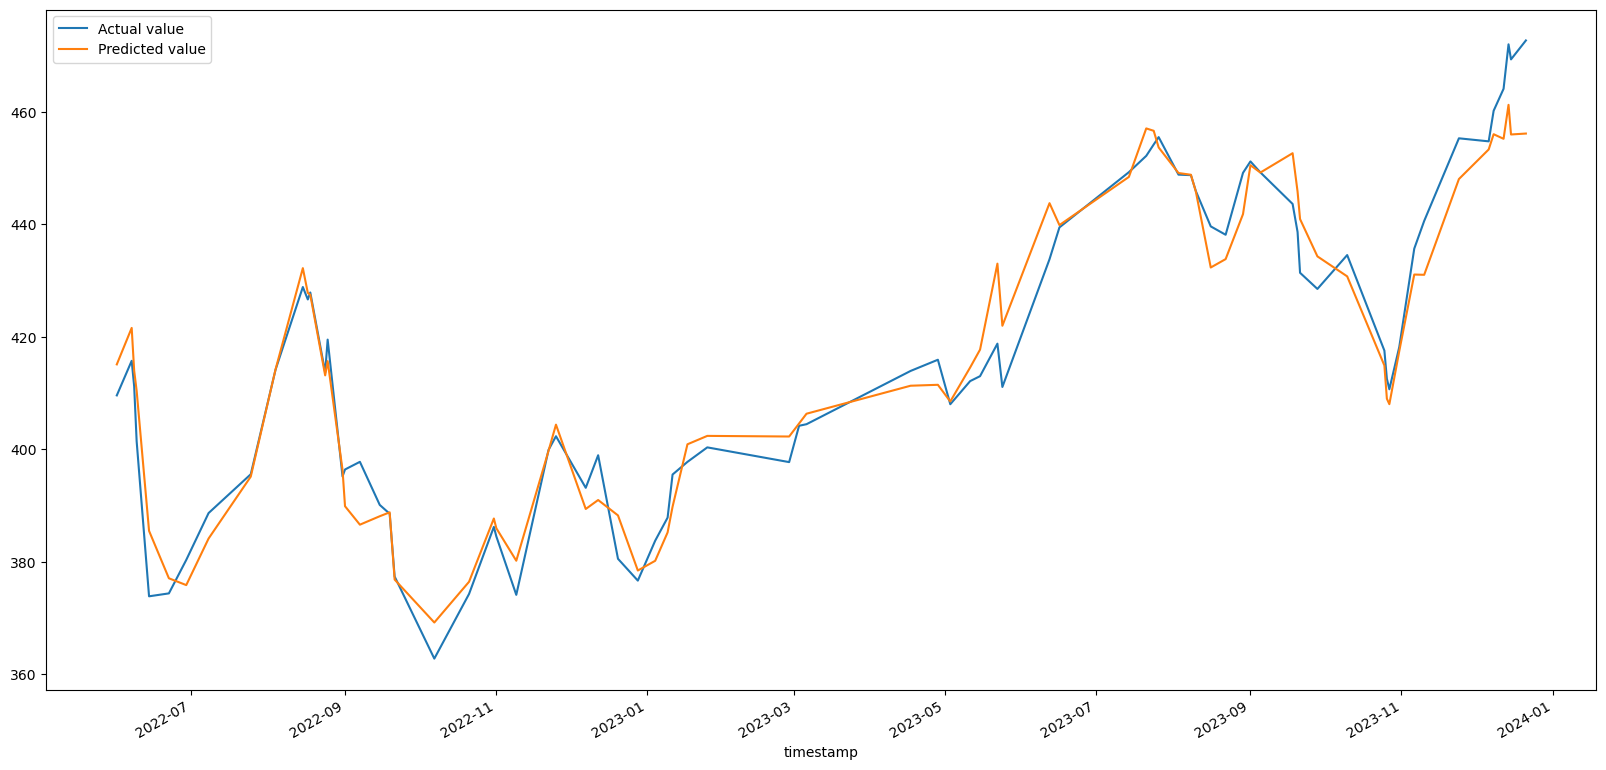

In [30]:
#20
# Predicting the Test and Train set result 

y_pred= reg_model.predict(X_test)  
x_pred= reg_model.predict(X_train)

# Finding the difference between predicted and actual values- for reference of predictive accuracy of model
reg_model_diff = pd.DataFrame({'Actual value': y_test, 'Predicted value': y_pred})
reg_model_diff.plot(figsize=(20,10))

In [32]:
#21
# Display the regression output into the GUI for analysis
reg_model.score(X,y)
print(f"Accuracy of model is {round(reg_model.score(X,y),4)*100}%")

Accuracy of model is 95.56%
